# Titanic

Author: Hoàng Trúc Chi

This notebook contains a comprehensive data analysis and processing of the [Titanic Kaggle challenge](https://www.kaggle.com/c/titanic)

---

## 1. Imports

In [1]:
import os
os.makedirs('/root/.kaggle', exist_ok=True)

from google.colab import files
files.upload()

! mv kaggle.json /root/.kaggle/
! chmod 600 /root/.kaggle/kaggle.json

# Download the dataset from kaggle website
# https://www.kaggle.com/competitions/titanic/data
! kaggle competitions download -c titanic

# Unzip the downloaded .zip archive
! unzip titanic.zip

Saving kaggle.json to kaggle.json
  0% 0.00/34.1k [00:00<?, ?B/s]
100% 34.1k/34.1k [00:00<00:00, 17.0MB/s]
Archive:  titanic.zip
  inflating: gender_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

---

## 2. General description of the dataset

In [3]:
df = pd.read_csv('train.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


The dataset contains 11 columns where:
- **Pclass** is the ticket class
- **SibSp** is the number of siblings / spouses aboard the Titanic
- **Parch** is the number of parents / children aboard the Titanic
- **embarker** is the port of embarkation
  - C: Cherbourg
  - Q: Queenstown
  - S: Southhampton

In [5]:
df.isnull().sum()

,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,177
SibSp,0
Parch,0
Ticket,0
Fare,0


There are missing values in Age and Cabin features.
- As the Age is a numerical value, we will either fill the NaN values with the mean or the median. We can't drop so many samples as they represent one fourth of the whole dataset.
- A vast majority of cabin numbers are missing. It mainly comes from the fact that when passengers are registered as a group (family or siblings) all cabin numbers are attributed to one passenger of the group.  

**In this notebook, we choose not to process this feature.**

- There are 2 missing values for the port of embarkation. We can just delete these samples.

In [6]:
df['Pclass'].value_counts()

,count
Pclass,
3,491
1,216
2,184


There are twice more passengers in 3rd class than in 1st or 2nd class.

---

## 3. Data analysis

Here we focus on finding correlations between features.  
To do so we first plot the correlation matrix (covariance matrix normalized in $[-1,1]$)


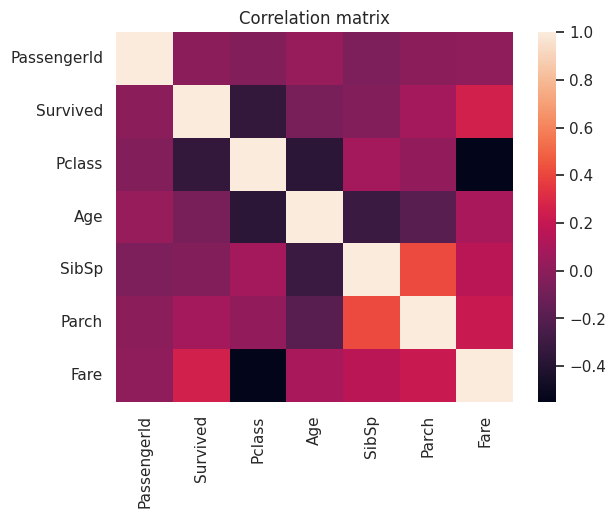

In [7]:
corr = df.corr(numeric_only=True)

plt.title('Correlation matrix')
sns.heatmap(corr)
plt.show()

We notice that:
- Passenger fare and ticket class (*Pclass column*) are inversely correlated, meaning that the lower the class index, the higher the ticket price.
- There is an obvious correlation between the number of siblings/spouses and the number of parents/children aboard. Couples are indeed more likely to have embarked with their children.
- Interestingly, passengers who paid more were also older. It makes sense as they were probably richer in average.
- **The survival rate is higher for people who paid higher fare, hence passengers of class 1 were mode likely to survive than passengers from classes 2 or 3.**
- **Equivalently, the higher the fare, the higher the survival rate.**

However, the correlation doesn't give much information about a potential relationship between the survival rate and data about the number of siblings/spouses/parents/children.

### 3.1 Categorical features

The correlation matrix only provide a coarse estimate on how categorical features vary with respect to other numerical features. Hence plot here more meaningful diagrams to better understand the distribution of these features.

We now focus on the ratio of passengers who survived for each category of the features we're interested in here:
- Passenger class: 1, 2 or 3
- Gender: male or female
- Siblings/spouse: between 0 and 8
- Parents/children: between 0 and 6
- Port of embarkation: C, Q or S

In [8]:
def cat_bar(feature):
  """Utility function to plot the Survived/Death ratio against a categorical feature"""
  grouped = df.groupby([feature, 'Survived']).size().unstack()
  total = grouped.sum(axis=1)
  ratio = grouped.div(total, axis=0)
  ratio = ratio.rename(columns={0: 'No', 1: 'Yes'})
  ratio.plot(kind='bar', stacked=True, color=['red', 'green'], rot=0).legend(loc='upper right', title='Survived')

#### 3.1.1 Passenger class

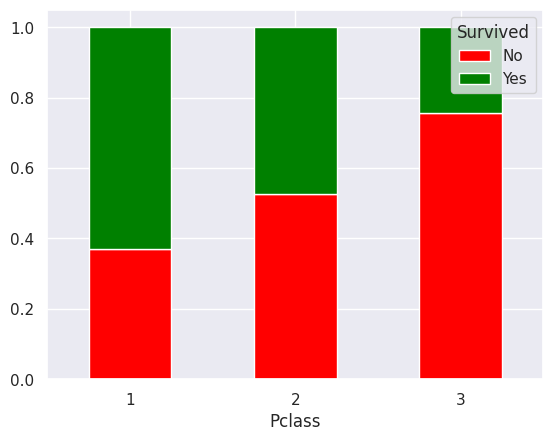

In [9]:
cat_bar('Pclass')

This chart confirms that people from upper classes are likely to survive.  
The survival rates are approximatively:
- 60% for 1st class passengers
- 50% for 2nd class passengers
- 20% for 3rd class passengers

#### 3.1.2 Passenger gender

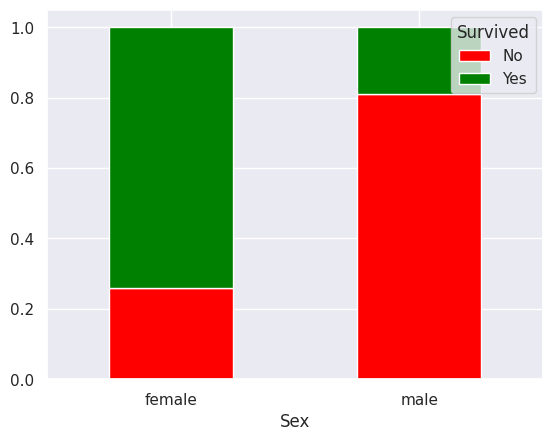

In [10]:
cat_bar('Sex')

We see here that around 75% of women survived, against only about 15% of men.  
**Hence there is a strong correlation between the gender of the passenger and it's survival rate.**

#### 3.1.3 Siblings and spouses

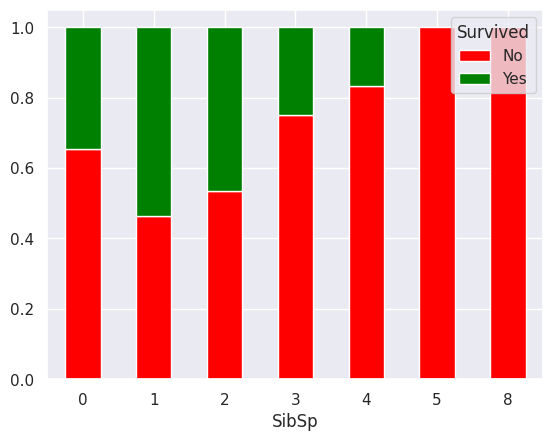

In [11]:
cat_bar('SibSp')

As we could logically expect, the survial rate decrease as the number of siblings increases. Passengers with several siblings might have tried to escape together, as a small group for instance. It probably made them more likely not to survive.

However, we can also notice that the survival rate is higher for passengers with one sibling than for single ones.

#### 3.1.4 Parents and children

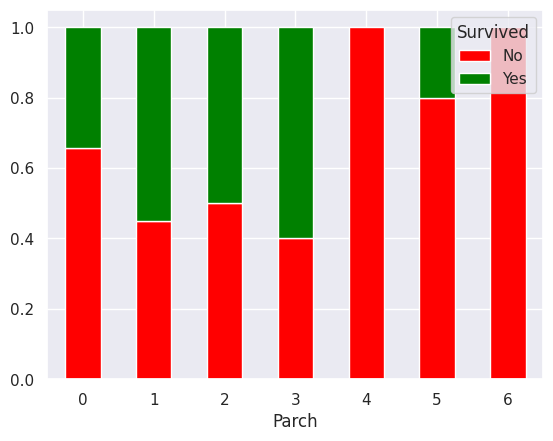

In [12]:
cat_bar('Parch')

In [13]:
# quick look at the number of samples with value 4, to understand why there's a 100% chance of dying
df[df['Parch']==4]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
167,168,0,3,"Skoog, Mrs. William (Anna Bernhardina Karlsson)",female,45.0,1,4,347088,27.900,NaN,S
360,361,0,3,"Skoog, Mr. Wilhelm",male,40.0,1,4,347088,27.900,NaN,S
438,439,0,1,"Fortune, Mr. Mark",male,64.0,1,4,19950,263.000,C23 C25 C27,S
567,568,0,3,"Palsson, Mrs. Nils (Alma Cornelia Berglund)",female,29.0,0,4,349909,21.075,NaN,S


Once again, single passengers have surprinsingly a lower survival rate than the ones being part of a family (parents or children).

*The anomaly of category 4 comes from the fact that there is only one such group, and they all died.*

#### 3.1.5 Port of embarkation

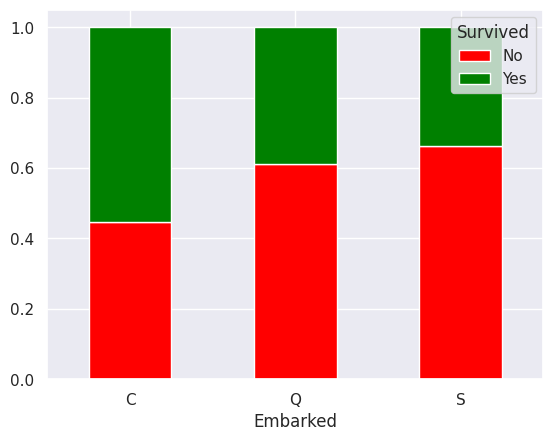

In [14]:
cat_bar('Embarked')

Passengers who embarked in Cherbourg are more likely to survive.

### 3.2 Continuous features

Here we handle non discrete features. The dataset contains twko such features:
- Age
- Fare

We is order to figure out how to process these features, we first visualize them. We aleady know from the correlation matrix that there is a link between passengers' age, fare and survival rate;  
passengers who paid the most belong to the 1st class, and they're also generally older.  
However, we can assume that due to their physical condition (**it's a purely subjective point of view**), younger passengers (in their 20's or 30's) should be more likely to survive than older passengers. The most reasonable prior reasoning consists in assuming that there a tradeoff between age and class.  
For instance, we could intuituively assume than a 80 years old passenger in 1st class may be less likely to survive than a 30 years old passenger in 2nd or 3rd class.


*Although the features are continuous by nature we have a finite set of samples. Hence we use kernel density estimation to approximate them with an actually continours distribution.*

In [15]:
def plot_dist(feature):
  """Utility function to plot the distributions of survived and non survived passengers with respect to a given feature"""
  facet = sns.FacetGrid(df, hue="Survived",aspect=4)
  facet.map(sns.kdeplot, feature, fill= True)
  facet.set(xlim=(0, df[feature].max()))
  facet.add_legend()

#### 3.2.1. Age

As mentioned in section 2., one fourth of age data are missing. The correlation matrix also shows a strong correlation between Age and Class.  
Hence, missing values will be filled with the median age of the class. In other words, if a passenger from 1st class has missing age, it's filled with the median age across 1st class passengers.

*We choose the median over the mean because there might be some outliers (i.e samples that don't reflect the majority of passengers among one given class). For example, we could have a 25 years old passenger in first class, which would be way youger than the median age.

In [16]:
df['Age'].fillna(df.groupby('Pclass')['Age'].transform('median'), inplace=True)

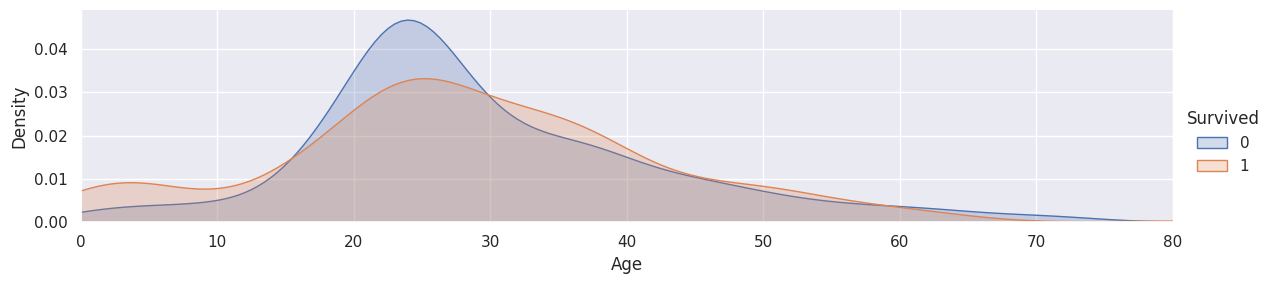

In [17]:
plot_dist('Age')

We can observe clear trends in the distribution of passengers who survived or not with respect to the age. We also notice that the distribution is imbalanced, especially for very young (<15) and aged people (>60).

**Hence we apply data binning to extract the general trends for every age group.**

We create the following age groups:
- 0: [0,15[
- 1: [15,30[
- 2: [30,60[
- 3: [60, 80]

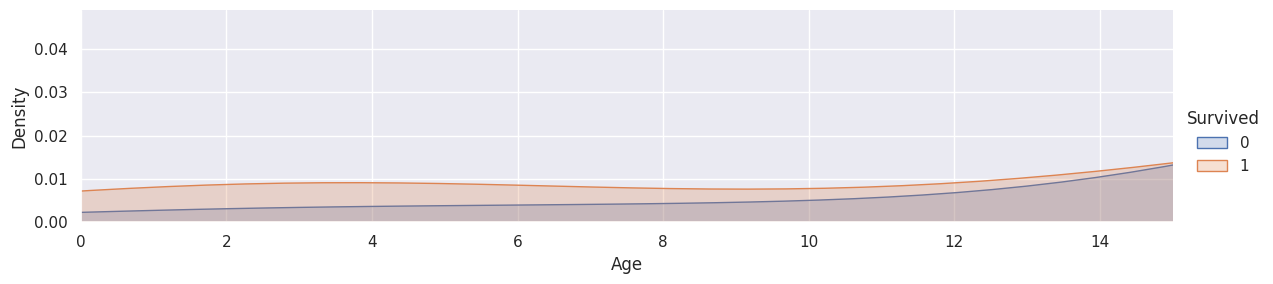

In [18]:
plot_dist('Age')
plt.xlim(0,15)
plt.show()

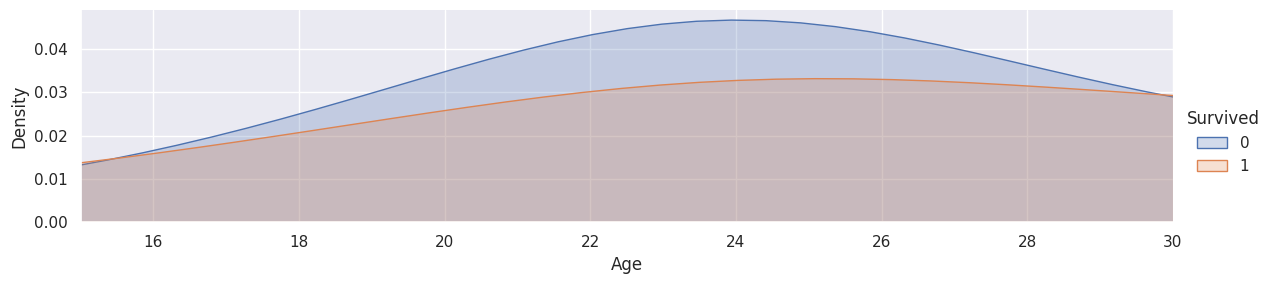

In [19]:
plot_dist('Age')
plt.xlim(15,30)
plt.show()

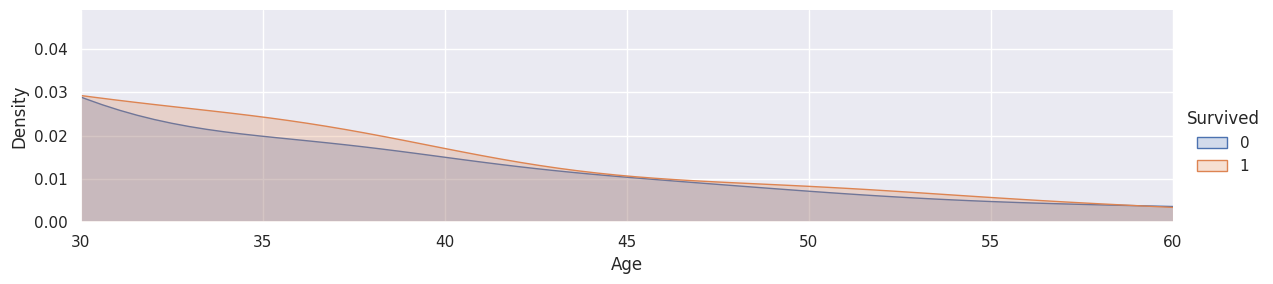

In [20]:
plot_dist('Age')
plt.xlim(30,60)
plt.show()

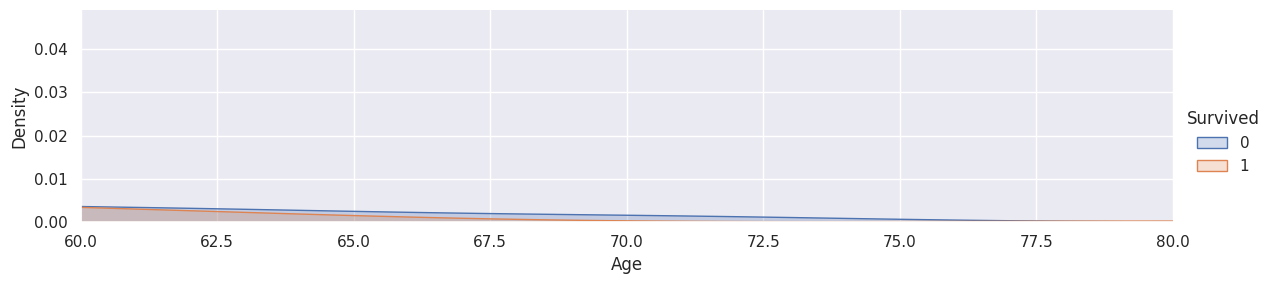

In [21]:
plot_dist('Age')
plt.xlim(60, 80)
plt.show()

In [22]:
bins = [0,15,30,60,80]
labels = [i for i in range(len(bins)-1)]

df['Age'] = pd.cut(df['Age'], bins=bins, labels=labels)
df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,1,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,2,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,1,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,2,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,2,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,1,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,2,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,1,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,0,1,0,237736,30.0708,NaN,C


<ipython-input-8-939bc7384cf0>:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby([feature, 'Survived']).size().unstack()


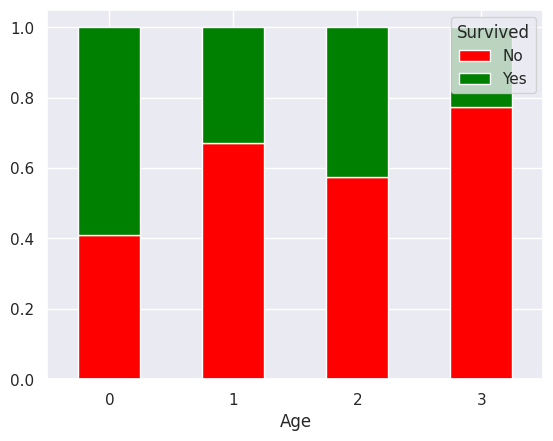

In [23]:
cat_bar('Age')

We can clearly see here that children from 0 to 15 years old are the passengers who actually have the highest survival rate, where oldest ones have the lowest.

#### 3.2.2 Fare

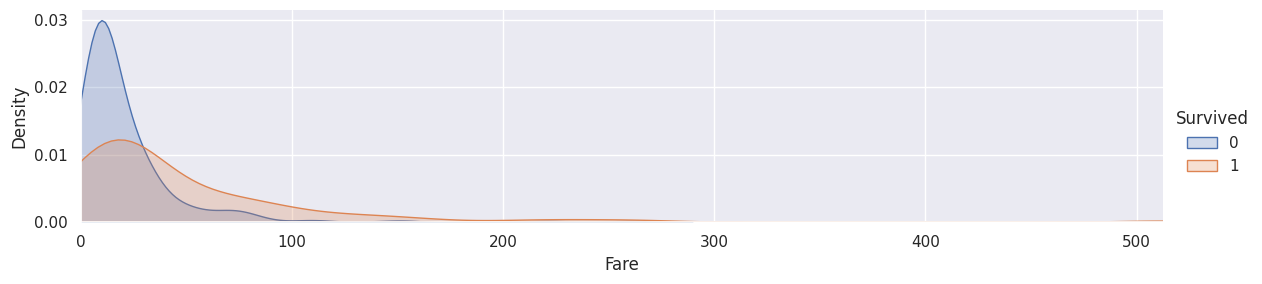

In [24]:
plot_dist('Fare')

Tehre are 3 different trends:
- [0,30[: passengers mainly died
- [30,120[: passengers mainly survived
- \>120: Everyone survived

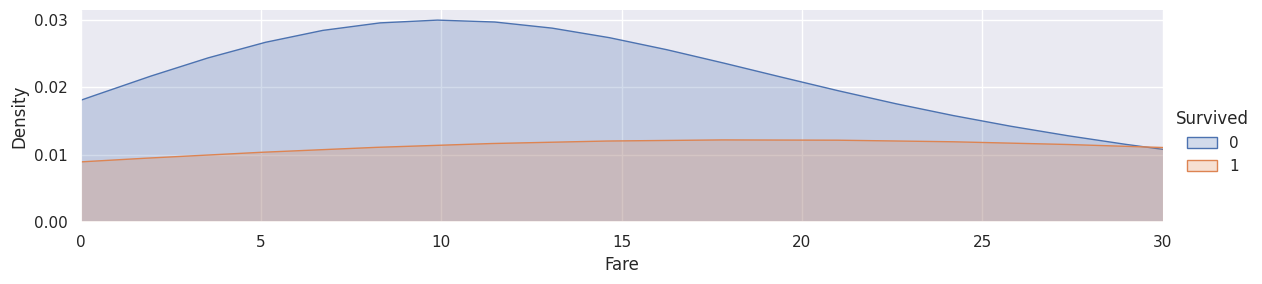

In [25]:
plot_dist('Fare')
plt.xlim(0,30)
plt.show()

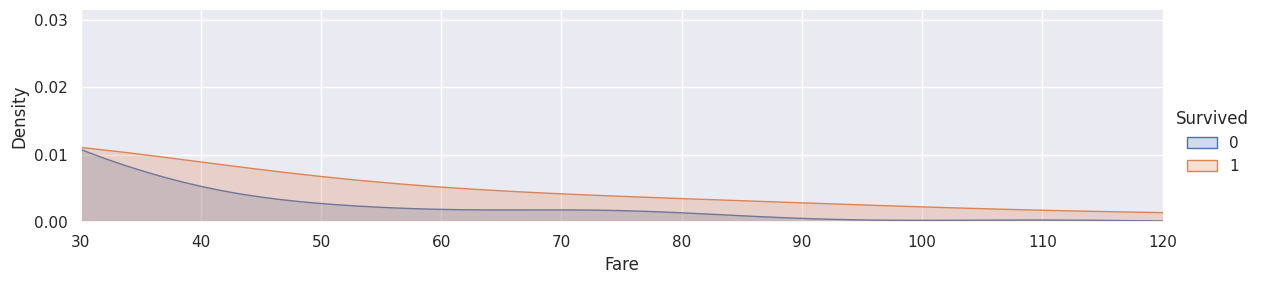

In [26]:
plot_dist('Fare')
plt.xlim(30,120)
plt.show()

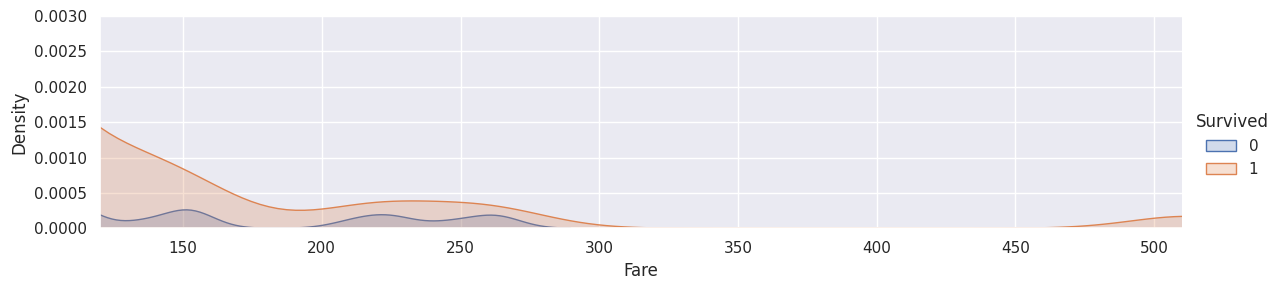

In [27]:
# Y scale was changed for sake of readibility
plot_dist('Fare')
plt.xlim(120, 510)
plt.ylim(0.0,0.003)
plt.show()

To extract these trends we use data binning again:

In [28]:
bins = [0,30,120,df['Fare'].max()]
labels = [i for i in range(len(bins)-1)]

df['Fare'] = pd.cut(df['Fare'], bins=bins, labels=labels)
df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,1,1,0,A/5 21171,0,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,2,1,0,PC 17599,1,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,1,0,0,STON/O2. 3101282,0,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,2,1,0,113803,1,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,2,0,0,373450,0,NaN,S
5,6,0,3,"Moran, Mr. James",male,1,0,0,330877,0,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,2,0,0,17463,1,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,0,3,1,349909,0,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,1,0,2,347742,0,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,0,1,0,237736,1,NaN,C


<ipython-input-8-939bc7384cf0>:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby([feature, 'Survived']).size().unstack()


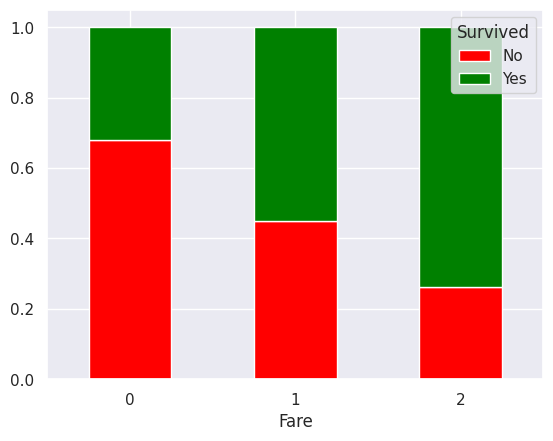

In [29]:
cat_bar('Fare')

We find back in a more consistent and meaningful way the strong correlation between the fare and the survival rate.

## Features engineering

Here we format all the features so taht they can be used as inputs for a machine learning model.

We start by applying several minor transformations to the dataset:
- Drop the Name, PassengerId, Ticket and Cabin columns.
- Drop the samples with no port of embarkation.
- Binarize passengers gender (male, female) $\rightarrow$ (0,1).
- Convert the embarked column to integers.

In [30]:
df.drop(['Name', 'PassengerId', 'Ticket', 'Cabin'], axis=1, inplace=True)
df.dropna(subset=['Embarked'], inplace=True)
df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})
df['Embarked'] = df['Embarked'].map({'C': 0, 'Q': 1, 'S': 2})
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,0,1,1,0,0,2
1,1,1,1,2,1,0,1,0
2,1,3,1,1,0,0,0,2
3,1,1,1,2,1,0,1,2
4,0,3,0,2,0,0,0,2


### TODO

- process family numbers
- process cabin numbers